In [27]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import potentials
from distances import *
from scipy.special import erfc

In [28]:
class Ewald(object):
    def __init__(self, alpha, sigma, r_cutoff, k_cutoff, accuracy):
        self.L = r_cutoff*2 #minimum image convention
        self.vol = L**3
        self.a = alpha
        self.s = sigma
        self.rc = r_cutoff
        self.kc = k_cutoff
        self.e = accuracy
        
    def image_coord(coord, i, j):
        return coord + [self.L*i, self.L*j]
    
    def pot_sr(self, coord, charges):
        #images =
        dist = distances(vectors(coord, pbc=True))
        mask = dist<=self.rc
        dist[dist!=0] = 1/dist[dist!=0]
        dist_ma = np.ma.masked_array(dist, mask)
        return 1/2 * charges * np.ma.dot(erfc(self.a*dist_ma), charges)
    def pot_lr(self, coord, charges):
        pass

In [29]:
coord = np.asarray([[1.,0], [2,5], [6, 1]])
vec = -vectors(coord,pbc=True, L=7)
dis = distances(vec)
charges = np.asarray([1, -2, 1])

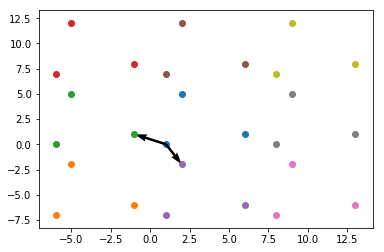

In [30]:
nb_images = np.asarray([coord + [7*a, 7*b] for a in range(-1,2) for b in range(-1,2) if  not (a==0 and b==0)])
plt.scatter(coord[:,0],coord[:,1])
plt.quiver([1,1],[0,0],vec[0,1:,0],vec[0,1:,1],scale=1,scale_units='xy', angles='xy')
for i in range(8):
    plt.scatter(nb_images[i,:,0], nb_images[i,:,1])